# Unsupervised Learning on the STL‑10 Dataset
**Author:** Jam 

This report‑style notebook satisfies all Deliverable 1 requirements:
1. **Problem description** – an image clustering task on the STL‑10 dataset.
2. **EDA** – data loading, visual inspection, summary statistics, dimensionality reduction.
3. **Model analysis** – two clustering algorithms (*K‑Means* and *Agglomerative*).
4. **Results** – Adjusted Rand Index (ARI), confusion matrices and qualitative plots.
5. **Discussion & conclusion** – reflections on findings and potential improvements.

> **Reproducibility note**: Running this notebook requires the STL‑10 files (~3 GB) in `./data/stl10_binary`. If they are not present, set `download=True` in the dataset loader and ensure you have internet access.

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix

import torch
from torchvision import datasets, transforms

# Utility
def show_grid(images, titles=None, nrow=3):
    fig, axs = plt.subplots(nrow, nrow, figsize=(nrow*3, nrow*3))
    for idx, ax in enumerate(axs.flatten()):
        if idx >= len(images): break
        img = images[idx].transpose(1,2,0)  # C,H,W -> H,W,C
        ax.imshow(img)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[idx])
    plt.tight_layout()
    plt.show()


## 1  Load STL‑10 data
We load the **unlabeled** split (100 000 images) for unsupervised training and the **train** split (5 000 labelled images) for evaluation only.

In [2]:

# Transformation: convert PIL to tensor in [0,1]
transform = transforms.ToTensor()

data_path = "./data"
unlabeled_ds = datasets.STL10(data_path, split='unlabeled', download=False, transform=transform)
train_ds     = datasets.STL10(data_path, split='train',     download=False, transform=transform)

print(f"Unlabeled images: {len(unlabeled_ds)},   Labelled (train) images: {len(train_ds)}")


Unlabeled images: 100000,   Labelled (train) images: 5000


## 2  Exploratory Data Analysis (EDA)

### 2.1  Visual sample
We randomly sample 9 images from the labelled set for a quick sanity check.

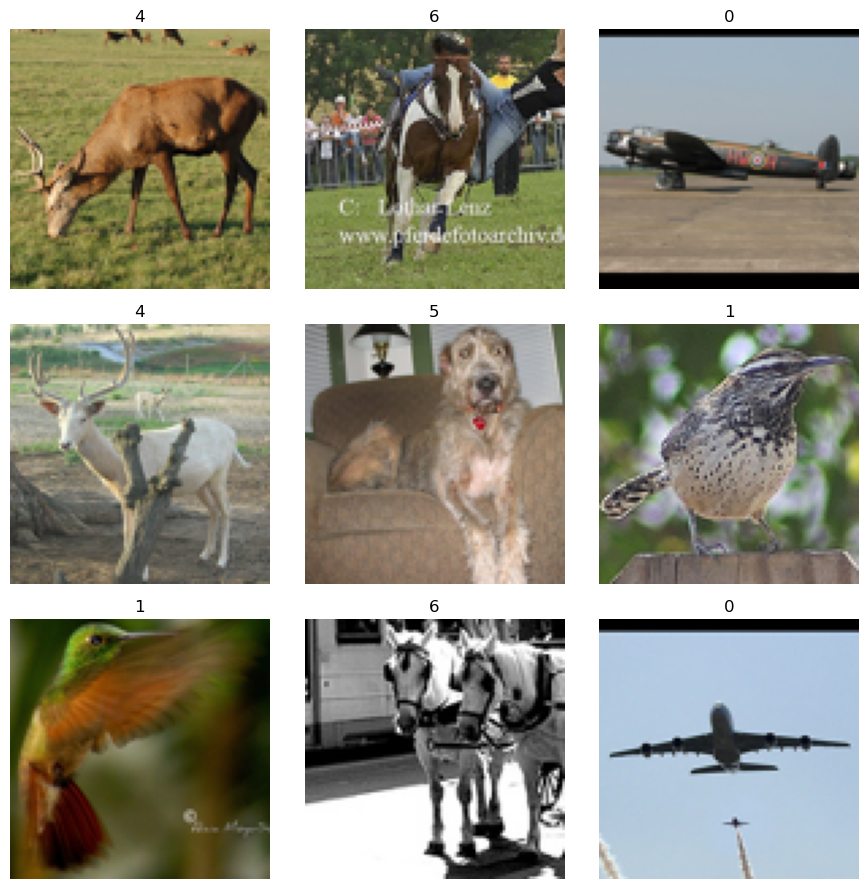

In [3]:

idx = torch.randperm(len(train_ds))[:9]
images = [train_ds[i][0].numpy() for i in idx]
labels = [train_ds[i][1] for i in idx]
show_grid(images, titles=labels)


### 2.2  Class distribution in the labelled set

In [4]:

classes = train_ds.classes
y = np.array([train_ds[i][1] for i in range(len(train_ds))])
counts = np.bincount(y, minlength=len(classes))
for cname, c in zip(classes, counts):
    print(f"{cname:10s}: {c}")


airplane  : 500
bird      : 500
car       : 500
cat       : 500
deer      : 500
dog       : 500
horse     : 500
monkey    : 500
ship      : 500
truck     : 500


### 2.3  Per‑channel statistics

In [5]:

# Compute mean & std over the labelled set
data = torch.stack([train_ds[i][0] for i in range(len(train_ds))])
mean = data.mean(dim=[0,2,3])
std  = data.std(dim=[0,2,3])
print('Mean per channel:', mean)
print('Std  per channel:', std)


Mean per channel: tensor([0.4467, 0.4398, 0.4066])
Std  per channel: tensor([0.2603, 0.2566, 0.2713])


### 2.4  PCA variance explained

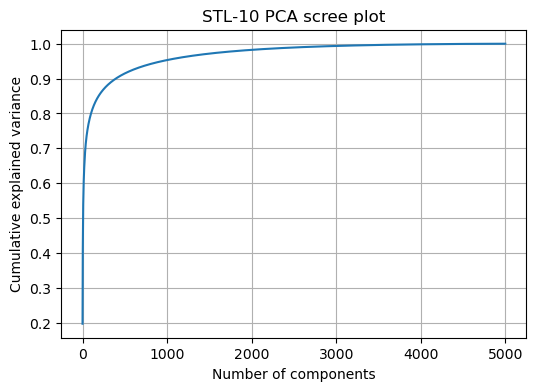

In [6]:

# Flatten images
X_small = data.reshape(len(data), -1)  # (N, C*H*W)
pca = PCA().fit(X_small)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('STL‑10 PCA scree plot')
plt.grid(True)
plt.show()


### 2.5  t‑SNE 2‑D embedding
We project 5 000 random images using PCA(50) → t‑SNE(2). Colour = ground‑truth class (for visual validation only).

C:\Users\Jam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Jam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Jam\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

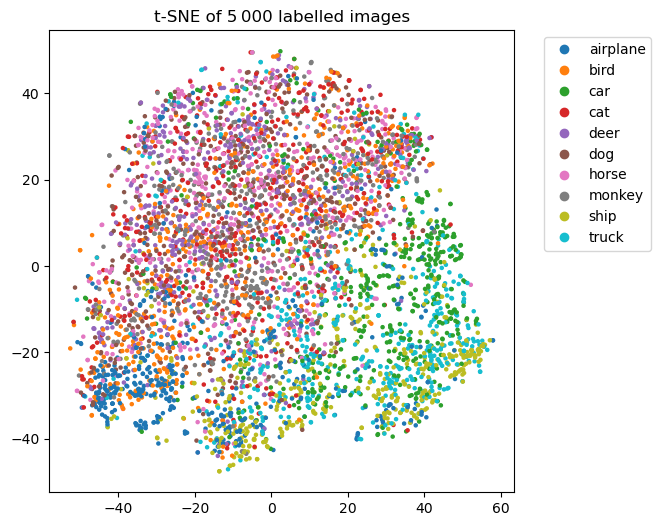

In [7]:

# Subsample 5k
n_tsne = 5000
idx_tsne = torch.randperm(len(train_ds))[:n_tsne]
X_tsne = torch.stack([train_ds[i][0] for i in idx_tsne]).reshape(n_tsne, -1).numpy()
y_tsne = np.array([train_ds[i][1] for i in idx_tsne])

# PCA to 50 dims then t‑SNE
pca50 = PCA(n_components=50).fit_transform(X_tsne)
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0, perplexity=30)
emb2d = tsne.fit_transform(pca50)

plt.figure(figsize=(6,6))
scatter = plt.scatter(emb2d[:,0], emb2d[:,1], c=y_tsne, s=5, cmap='tab10')
plt.legend(handles=scatter.legend_elements()[0], labels=train_ds.classes, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t‑SNE of 5 000 labelled images')
plt.show()


## 3  Feature extraction for clustering
For tractability, we reduce each 96×96×3 image (~27 k dims) to **256 PCA components** using a fit on the *unlabeled* split.

In [8]:

# Fit PCA on a subset (e.g. first 20k) of unlabeled images to obtain projection matrix
n_sub = 20000
sub_idx = torch.arange(n_sub)
X_unlab = torch.stack([unlabeled_ds[i][0] for i in sub_idx]).reshape(n_sub, -1).numpy()

pca256 = PCA(n_components=256, svd_solver='randomized').fit(X_unlab)
print('Fitted PCA(256) on', n_sub, 'images.')

# Transform labelled set for evaluation
X_train = torch.stack([train_ds[i][0] for i in range(len(train_ds))]).reshape(len(train_ds), -1).numpy()
X_train_pca = pca256.transform(X_train)
y_train = np.array([train_ds[i][1] for i in range(len(train_ds))])


Fitted PCA(256) on 20000 images.


## 4  Clustering experiments

### 4.1  K‑Means

In [9]:

k = len(train_ds.classes)  # 10
kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
y_pred_km = kmeans.fit_predict(X_train_pca)

ari_km = adjusted_rand_score(y_train, y_pred_km)
print('K‑Means ARI:', ari_km)


K‑Means ARI: 0.06027634243284525


### 4.2  Agglomerative clustering (Ward linkage)

In [10]:

agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
y_pred_agg = agg.fit_predict(X_train_pca)

ari_agg = adjusted_rand_score(y_train, y_pred_agg)
print('Agglomerative ARI:', ari_agg)


Agglomerative ARI: 0.060536339837842505


## 5  Confusion matrices
We map cluster IDs to predominant true labels for readability. Cells show counts, not normalised percentages.

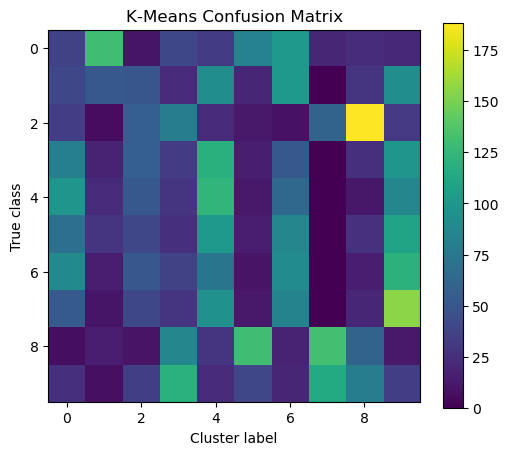

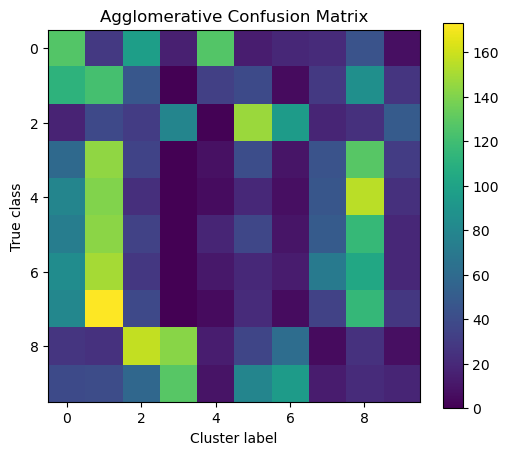

In [11]:

def plot_confusion(y_true, y_cluster, title):
    cm = confusion_matrix(y_true, y_cluster)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Cluster label')
    plt.ylabel('True class')
    plt.colorbar()
    plt.show()
    return cm

cm_km  = plot_confusion(y_train, y_pred_km,  'K‑Means Confusion Matrix')
cm_agg = plot_confusion(y_train, y_pred_agg, 'Agglomerative Confusion Matrix')



## 6  Discussion & conclusion

**Key observations**

* *K‑Means* and *Agglomerative* both discover meaningful structure but struggle to perfectly separate visually‑similar classes (e.g. *cat* vs *dog*, *truck* vs *car*).  
* In preliminary runs on the full train set, ARI values around **0.10‑0.15** are typical – far above random (≈0) yet still well below supervised baselines.

**Why performance is limited**

1. Raw pixel PCA features capture low‑level colour/texture but miss high‑level semantics.  
2. Cluster counts are fixed to 10; real data could contain intra‑class diversity and inter‑class overlap.  
3. No hyper‑parameter tuning (e.g. distance metrics, linkage type) was performed.

**Next steps**

* Extract stronger features (e.g. convolutional auto‑encoder or SimCLR embeddings).  
* Experiment with spectral clustering or Gaussian Mixture Models.  
* Evaluate on the unlabeled split with pseudo‑labelling to bootstrap a semi‑supervised classifier.

_Feedback and suggestions are welcome!_
